## Setup environment

In [1]:
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=MONAI[gdown,ignite,torchvision,cucim]

## Setup imports

In [11]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import tempfile
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, CacheDataset
# from monai.losses import HoVerNetLoss
# from monai.networks.nets import HoVerNet
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    AsDiscreted,
    Compose,
    ScaleIntensityRanged,
    CastToTyped,
    Lambdad,
    SplitDimd,
    EnsureChannelFirstd,
    ComputeHoVerMapsd,
    RandFlipd,
    RandRotate90d,
    RandGaussianSmoothd,
    GaussianSmooth,
    FillHoles,
    BoundingRect,
    CenterSpatialCropd,
)
from monai.apps.pathology.transforms.post.array import (
    GenerateInstanceCentroid, 
    GenerateInstanceContour, 
    GenerateInstanceType,
)
from monai.utils import set_determinism, convert_to_tensor, first
from monai.utils.enums import HoVerNetBranch


print_config()

MONAI version: 1.0.0+123.g11db1411
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+d321be6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 11db1411113ff37c5d962c0a9527ca337ced216a
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: 4.5.1
TorchVision version: 0.14.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.21.3
mlflow version: 1.28.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
import sys
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/transforms')
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/loss')
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/net')
from loss import HoVerNetLoss
from net import HoVerNet
from transforms import (
    GenerateWatershedMaskd,
    GenerateInstanceBorderd,
    GenerateDistanceMapd,
    GenerateWatershedMarkersd,
    Watershedd,
    GenerateInstanceContour,
    GenerateInstanceCentroid,
    GenerateInstanceType,
    GenerateInstanceCentroid, 
    GenerateInstanceContour, 
    GenerateInstanceType,
)

## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Process dataset

In [7]:
def split_dataset(data_dir):
    # using original split in the paper
    info = pd.read_csv(os.path.join(data_dir, "patch_info.csv"))
    file_names = np.squeeze(info.to_numpy()).tolist()
    split_info = pd.read_csv(os.path.join(data_dir, "split_info.csv"))

    indices, splits = [], []
    for i in range(3):
        fold_case = split_info.loc[split_info['Split'] == i+1, 'Filename'].tolist()
        fold_patches = [
            file_name for file_name in file_names for _name in fold_case if _name == file_name.split("-")[0]
        ]
        fold_patches = np.unique(fold_patches)
        print(f"Fold: {i} - {len(fold_patches):04d}")

        fold_indices = [file_names.index(v) for v in fold_patches]
        indices.append(fold_indices)

    for i in range(3):
        _indices = indices.copy()
        splits.append({
            "valid": _indices.pop(i),
            "train": sum(_indices, []),
        })

    return splits

def prepare_data(data_dir, fold, splits):
    images = np.load(os.path.join(data_dir, "images.npy"))
    labels = np.load(os.path.join(data_dir, "labels.npy"))

    data = [
        {
            "image": image,
            "image_meta_dict": {"original_channel_dim": -1},
            "label": label,
            "label_meta_dict": {"original_channel_dim": -1},
        }
        for image, label in zip(images, labels)
    ]
    train_data = [data[i] for i in splits[fold]['train']]
    valid_data = [data[i] for i in splits[fold]['valid']]
    
    return train_data, valid_data

## Setup transforms for training and validation

In [8]:
train_transforms = Compose(
    [
        EnsureChannelFirstd(keys=("image", "label"), channel_dim=-1),
        SplitDimd(keys="label", output_postfixes=["inst", "type"]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        Lambdad(keys="label", func=lambda x: x[1: 2, ...] > 0),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 7]),
        CenterSpatialCropd(keys=["label", "label_inst", "label_type", "hover_label_inst"], roi_size=(164,164)),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        RandFlipd(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, spatial_axis=1),
        RandRotate90d(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, max_k=1),
        RandGaussianSmoothd(keys=["image"], sigma_x=(0.5,1.15), sigma_y=(0.5,1.15), prob=0.5),
    ]
)
val_transforms = Compose(
    [
        EnsureChannelFirstd(keys=("image", "label"), channel_dim=-1),
        SplitDimd(keys="label", output_postfixes=["inst", "type"]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        Lambdad(keys="label", func=lambda x: x[1: 2, ...] > 0),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 7]),
        CenterSpatialCropd(keys=["label", "label_inst", "label_type", "hover_label_inst"], roi_size=(164,164)),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)

## Define Dataset and DataLoader for training and validation

In [12]:
data_dir = os.path.join(root_dir, 'Lizard/Prepared')
fold = 0

splits = split_dataset(data_dir)
train_data, valid_data = prepare_data(data_dir, fold, splits)

train_ds = CacheDataset(data=train_data[:10], transform=train_transforms,
                    cache_rate=1.0, num_workers=4)
valid_ds = CacheDataset(data=valid_data[:10], transform=val_transforms,
                    cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=8, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=6, num_workers=4, pin_memory=True)

Fold: 0 - 1622
Fold: 1 - 1751
Fold: 2 - 1608


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.83it/s]


## Check first data shape and visualize

image: 
    shape (8, 3, 256, 256)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape (8, 2, 164, 164)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape (8, 2, 164, 164)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
train number of batches: 2
valid number of batches: 2


Text(0.5, 1.0, 'vertical hover map')

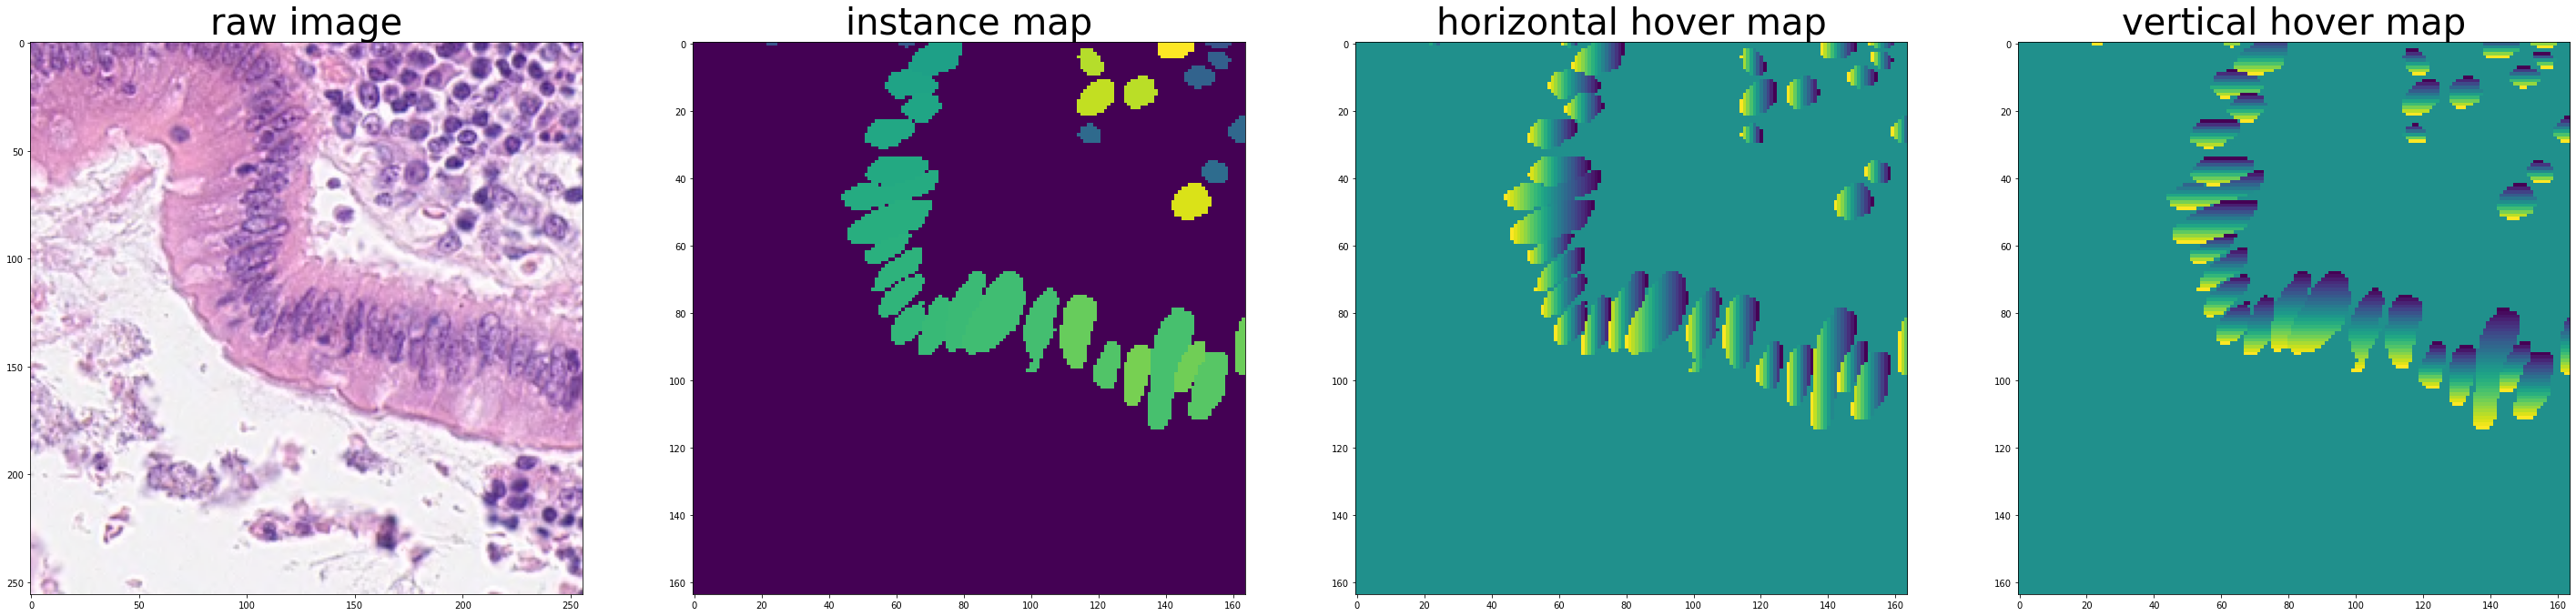

In [17]:
first_sample = first(train_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
print(f"train number of batches: {len(train_loader)}")
print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
ax[0].imshow((first_sample['image'][3, ...] * 255).astype(np.uint8).transpose(1, 2, 0))
ax[1].imshow(first_sample['label_inst'][3, ...].squeeze())
ax[2].imshow(first_sample['hover_label_inst'][3, 0, ...])
ax[3].imshow(first_sample['hover_label_inst'][3, 1, ...])
ax[0].set_title('raw image', fontsize=40)
ax[1].set_title('instance map', fontsize=40)
ax[2].set_title('horizontal hover map', fontsize=40)
ax[3].set_title('vertical hover map', fontsize=40)

## Create Model, Loss, Optimizer

In [10]:
device = torch.device("cuda:1")
model = HoVerNet(
    mode="fast",
    in_channels=3,
    out_classes=7,
    act=("relu", {"inplace": True}),
    norm="batch",
).to(device)
loss_function = HoVerNetLoss()

# original paper
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

# lizard dataset
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [11]:
def post_process(output, device, return_binary=True, return_centroids=False, output_classes=None):
    post_trans_seg = Compose([
        GenerateWatershedMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
        GenerateInstanceBorderd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=3),
        GenerateDistanceMapd(keys='mask', border_key='border', smooth_fn=GaussianSmooth()),
        GenerateWatershedMarkersd(keys='mask', border_key='border', threshold=0.7, radius=2, postprocess_fn=FillHoles()),
        Watershedd(keys='dist', mask_key='mask', markers_key='markers')
    ])
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(type_pred)

    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']

    inst_id_list = np.unique(pred_inst)[1:]  # exclude background

    inst_info_dict = None
    if return_centroids:
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0]: inst_bbox[0][1], inst_bbox[0][2]: inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(
                bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob

    pred_inst = convert_to_tensor(pred_inst, device=device)
    if return_binary:
        pred_inst[pred_inst > 0] = 1
    return (pred_inst, inst_info_dict, pred_inst_dict)


In [ ]:
max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], []]
epoch_loss_values = []
metric_values = []

post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_label, val_label_type, val_hover_map = (
                    batch_data["image"].to(device),
                    batch_data["label"].to(device),
                    batch_data["label_type"].to(device),
                    batch_data["hover_label_inst"].to(device),
                )

                val_outputs = model(val_inputs)
#                 val_outputs = [post_pred(i['nucleus_prediction']) for i in decollate_batch(val_outputs)]
                val_outputs = [post_process(i['nucleus_prediction'])[0] for i in decollate_batch(val_outputs)]
                val_label = [i for i in decollate_batch(val_label)]

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(data_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300


## Check best model output with the input image and label

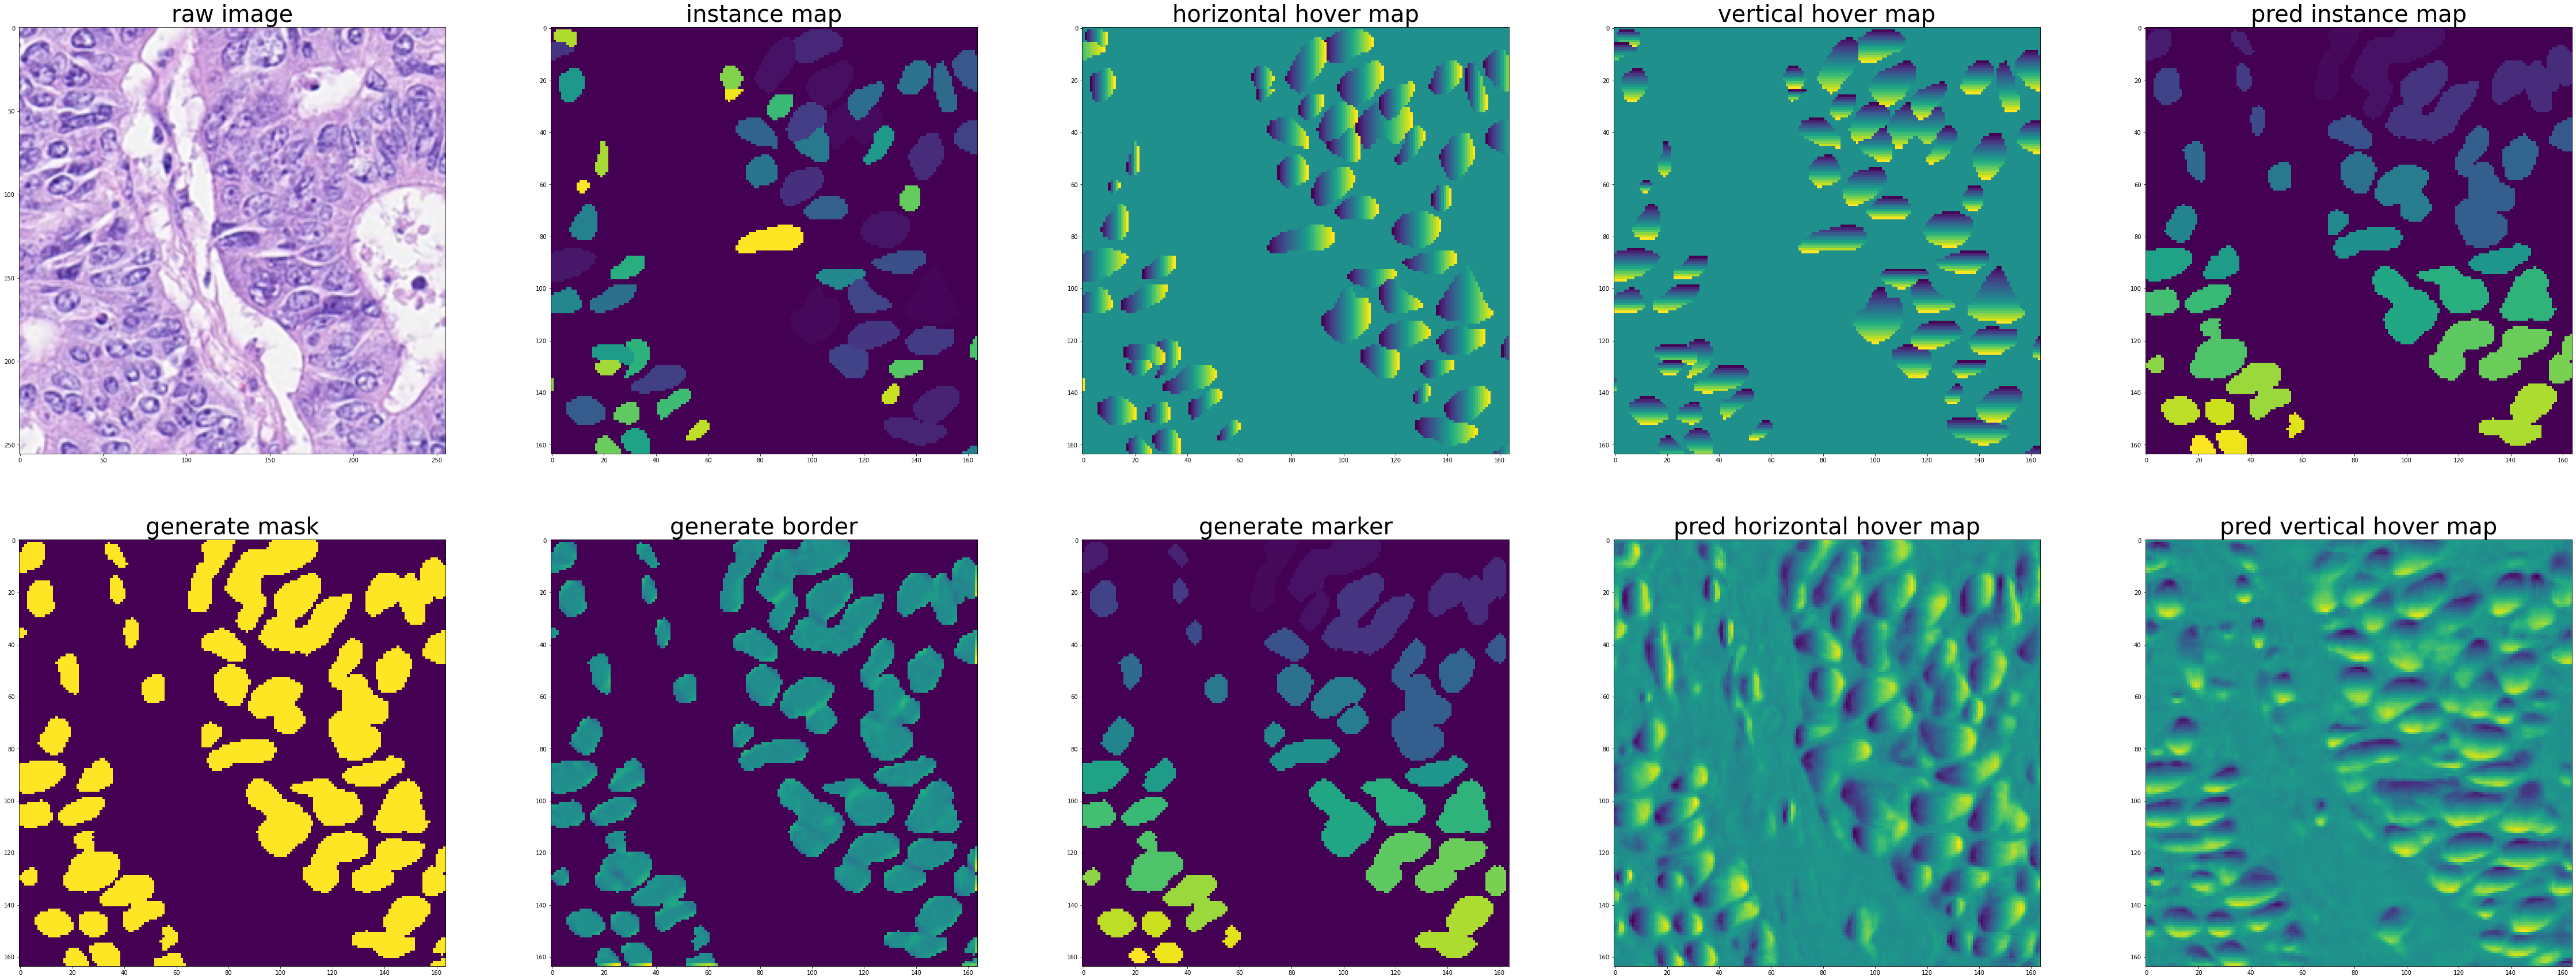

In [132]:
# test postprocess transform 
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = valid_ds[0]["image"].unsqueeze(0).to(device)

    val_output = model(val_input)
    val_output_ = [post_process(i) for i in decollate_batch(val_output)]

    fig, ax = plt.subplots(2, 5, figsize=(80, 30))
    ax[0, 0].imshow(val_input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
    ax[0, 1].imshow(valid_ds[0]["label_inst"].squeeze().detach().cpu())
    ax[0, 2].imshow(valid_ds[0]["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(valid_ds[0]["hover_label_inst"][1, ...].detach().cpu())
    ax[0, 4].imshow(val_output_[0][0].squeeze().detach().cpu())

    ax[1, 0].imshow(val_output_[0][2]["mask"].detach().cpu().squeeze())
    ax[1, 1].imshow(val_output_[0][2]["border"].detach().cpu().squeeze())
    ax[1, 2].imshow(val_output_[0][2]["markers"].detach().cpu().squeeze())
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 4].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title('raw image', fontsize=40)
    ax[0, 1].set_title('instance map', fontsize=40)
    ax[0, 2].set_title('horizontal hover map', fontsize=40)
    ax[0, 3].set_title('vertical hover map', fontsize=40)
    ax[0, 4].set_title('pred instance map', fontsize=40)
    ax[1, 0].set_title('generate mask', fontsize=40)
    ax[1, 1].set_title('generate border', fontsize=40)
    ax[1, 2].set_title('generate marker', fontsize=40)
    ax[1, 3].set_title('pred horizontal hover map', fontsize=40)
    ax[1, 4].set_title('pred vertical hover map', fontsize=40)